Da svolgere in un ambiente con GPU

## 0.1 Package da installare

In [ ]:
%pip install segmentation-models

     |████████████████████████████████| 51kB 4.9MB/s 


## 0.2 Import utilizzati

In [ ]:
import tensorflow as tf
import segmentation_models as sm
import glob
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt
import keras 

import keras.utils # normalize da trovare, da dove viene
from keras.metrics import MeanIoU, Accuracy, Precision, Recall, TrueNegatives

In [ ]:
import segmentation_models

Sfruttando la libreria Segmentation models: https://github.com/qubvel/segmentation_models

## 1.1 Dati da estrarre dalla cartella del Drive

In [ ]:
# RESIZE delle immagini per non consumare tutte le risorse
SIZE_X= 256
SIZE_Y= 256

Pensare di dare nomi diversi alle directory delle immagini e delle maschere


In [ ]:
# IMAGES

directory='/content/drive/MyDrive/Computer Vision Project/Code/Dataset/da fare estrarre/images/'
fine_file1= '0_r.jpg' #* .
fine_file2= '0_e.jpg'
fine_file3= '0_d.jpg'
fine_file4= '0_f.jpg'
c=0; v=0

file_save_images=[]
images_save=[]

for j in sorted(os.listdir(directory)):
    if j.endswith(fine_file1):
        print(j)
        v= v+1
        file_save_images.append(j)

        pathe= os.path.join(directory, j)
        images= cv2.imread(pathe,1)
        images = cv2.resize(images, (SIZE_Y, SIZE_X)) #
        images_save.append(images)
    elif j.endswith(fine_file2):
        file_save_images.append(j)

        pathe= os.path.join(directory, j)
        images= cv2.imread(pathe,1)
        images = cv2.resize(images, (SIZE_Y, SIZE_X))
        images_save.append(images)

        v= v+1
    elif j.endswith(fine_file3):
        file_save_images.append(j)

        pathe= os.path.join(directory, j)
        images= cv2.imread(pathe,1)
        images = cv2.resize(images, (SIZE_Y, SIZE_X))
        images_save.append(images)

        v= v+1
    elif j.endswith(fine_file4):
        file_save_images.append(j)

        pathe= os.path.join(directory, j)
        images= cv2.imread(pathe,1)
        images = cv2.resize(images, (SIZE_Y, SIZE_X))
        images_save.append(images)

        v= v+1
    else:
        c=c+1

# divisione a metà, tra le immagini del modello ed immagini dell'abito (non usate in questa fase)
print(v)
print(c)

12141279ui_0_r.jpg
12148956eo_0_r.jpg
12176911ut_0_r.jpg
39978968uo_0_r.jpg
39988078ft_0_r.jpg
39988142sn_0_r.jpg
39990216um_0_r.jpg
39994183qh_0_r.jpg
380
380


In [ ]:
# array e sua dimensione
images_save= np.array(images_save)
images_save.shape

(380, 256, 256, 3)

In [ ]:
# Per copiare i file in una directory destinazione

# import shutil
# shutil.copy(src, dest)

In [ ]:
# MASKS

directory='/content/drive/MyDrive/Computer Vision Project/Code/Dataset/da fare estrarre/masks/'
c=0; v=0

file_save_masks=[]
masks_save=[]

for j in sorted(os.listdir(directory)):
    # print(j)
    v= v+1
    file_save_masks.append(j)

    pathe= os.path.join(directory, j)
    masks= cv2.imread(pathe,0) # da valutare il colore della maschera
    masks = cv2.resize(masks, (SIZE_Y, SIZE_X), interpolation = cv2.INTER_NEAREST)
    masks_save.append(masks)

print(v)

380


In [ ]:
masks_save= np.array(masks_save)
masks_save.shape

(380, 256, 256)

## -- Controllo dell'ordine delle immagini e delle maschere

## Non sono in ordine

Aggiungere visualizzazione di un'immagine e di una maschera e da controllare queste variabili

In [ ]:
file_save_images[0]

'12141279ui_0_r.jpg'

In [ ]:
file_save_masks[0]

'12141279ui_0_r.png'

In [ ]:
print(images_save.shape)
print(masks_save.shape)

(380, 256, 256, 3)
(380, 256, 256)


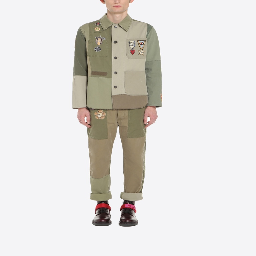

In [ ]:
# immaggine dei colori giusti
from google.colab.patches import cv2_imshow
cv2_imshow(images_save[0])

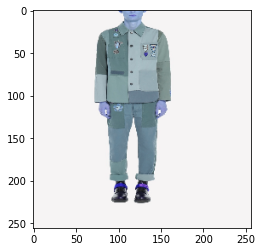

In [ ]:
plt.imshow(images_save[0])

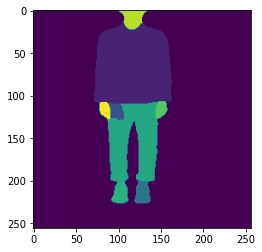

In [ ]:
plt.imshow(masks_save[0])

## 1.2 Pre-processing

Inizio il lavoro sulle maschere

In [ ]:
np.unique(masks_save)

array([  0,  14,  19,  33,  37,  38,  57,  72,  75,  89,  94, 108, 113,
       132, 147], dtype=uint8)

In [ ]:
# label encoder, per tutte le n immagini
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()

n, h, w= masks_save.shape
mask_reshape= masks_save.reshape(-1,1)
mask_reshape_encoded= labelencoder.fit_transform(mask_reshape)
mask_reshape_encoded_shape= mask_reshape_encoded.reshape(n,h,w)

np.unique(mask_reshape_encoded_shape)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])

In [ ]:
c= np.unique(mask_reshape_encoded_shape)
n_classes= len(c)
len(c)

15

In [ ]:
# aggiungo dimensione per avere la stessa dimensione delle immagini a colori

train_masks_input = np.expand_dims(mask_reshape_encoded_shape, axis=3)
train_masks_input.shape

(380, 256, 256, 1)

## 1.3 Split del dataset (train e test)

In [ ]:
'''
# DA SALTARE momentaneamente, per sfruttare tutte le immagini (visto che sono poche)
from sklearn.model_selection import train_test_split
X1, X_test, y1, y_test = train_test_split(images_save, train_masks_input, test_size = 0.10, random_state = 0)

#Further split training data t a smaller subset for quick testing of models
X_train, X_do_not_use, y_train, y_do_not_use = train_test_split(X1, y1, test_size = 0.5, random_state = 0)

print("Class values in the dataset are ... ", np.unique(y_train))  # 0 is the background/few unlabeled 
'''

Class values in the dataset are ...  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(images_save, train_masks_input, test_size = 0.20, random_state = 0)

Tra X ed y cambia il numero dei canali finali,
perchè le masks sono in bianco e nero (1) ed invece le immagini sono RGB (3)

In [ ]:
print(y_train.shape, y_test.shape)
print(X_train.shape) # X_test ha lo stesso numero di istanze di X_train

(304, 256, 256, 1) (76, 256, 256, 1)
(304, 256, 256, 3)


## 1.4 One Hot Encoder

In [ ]:
'''
a torch, b numpy
b = a.numpy()

a numpy, b torch
b = torch.from_numpy(a)
'''

Devo portare tutto in torch, 
poi faccio i calcoli ed alla fine riporto a numpy,
solo se devo e con la dimensione minore possibile.
Utilizzando la stessa variabile nell'assegnazione.

In [ ]:
mask_cat= np.zeros((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))
mask_cat.shape

(304, 256, 256, 15)

In [ ]:
# lavoro da fare sulle dimensioni del ricevente
# zeros di 4 dimensioni e vai a scorrere sul primo indice 

for i in range(y_train.shape[0]):
  mask_cat[i,:,:,:] = tf.keras.utils.to_categorical(y_train[i], num_classes=n_classes)
  #print(mask_cat.shape)
  #print(mask_cat[0].shape)
  
  y_train_cat = mask_cat.reshape((y_train.shape[0],y_train.shape[1], y_train.shape[2], n_classes))


In [ ]:
print(mask_cat.shape)
print(y_train_cat.shape)
# i valori che contengono sono 0, 1 per i vari assi, visto che si è applicato One Hot Encoder

(304, 256, 256, 15)
(304, 256, 256, 15)


In [ ]:
'''
from sklearn.preprocessing import OneHotEncoder

onehot= OneHotEncoder()
y_onehot= onehot.fit_transform(y_train).toarray() #y_train
y_train_cat = y_onehot.reshape(y_train.shape[0], 
                                y_train.shape[1], y_train.shape[2], n_classes)
'''

In [ ]:
# y_test: lavorando sempre con la parte y manipolo le maschere

mask_cat_test= np.zeros((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))

for i in range(y_test.shape[0]):
  mask_cat_test[i,:,:,:] = tf.keras.utils.to_categorical(y_test[i], num_classes=n_classes)
  #print(mask_cat.shape)
  #print(mask_cat[0].shape)
  
  y_test_cat = mask_cat_test.reshape((y_test.shape[0],y_test.shape[1], y_test.shape[2], n_classes))

In [ ]:
print(mask_cat_test.shape)
print(y_test_cat.shape)

(76, 256, 256, 15)
(76, 256, 256, 15)


## 2.1 Parameters of the model

In [ ]:
weights= np.zeros((n_classes))
for i in range(n_classes):
  weights[i]= 1/n_classes

In [ ]:
# n_classes=15
activation='softmax'

LR = 0.0001
optim = keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
# set class weights for dice_loss (car: 1.; pedestrian: 2.; background: 0.5;)
dice_loss = sm.losses.DiceLoss(class_weights=weights)
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore()]
# sm.metrics.Precision

## 2.2 Model_1

In [ ]:
sm.set_framework('tf.keras')
sm.framework()

BACKBONE1 = 'resnet34'
preprocess_input1 = sm.get_preprocessing(BACKBONE1)

In [ ]:
# X
X_train1 = preprocess_input1(X_train)
X_test1 = preprocess_input1(X_test)

# definizione
model1 = sm.Unet(BACKBONE1, encoder_weights='imagenet', classes=n_classes, activation=activation) # , encoder_freeze=True
# None, per il valore dei pesi: imagenet
#model1 = sm.FPN(BACKBONE1, encoder_weights='imagenet', classes=n_classes, activation=activation) # None, per il valore dei pesi: imagenet

model1.compile(optim, total_loss, metrics=metrics)

print(model1.summary())

Model: "model_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               [(None, None, None,  0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, None, None, 3 9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_256 (ZeroPadding (None, None, None, 3 0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, None, None, 6 9408        zero_padding2d_256[0][0]         
___________________________________________________________________________________________

In [ ]:
history1=model1.fit(X_train1, 
          y_train_cat,
          batch_size=8, 
          epochs=50, #2, 4, 50
          verbose=1,
          validation_data=(X_test1, y_test_cat))


Epoch 1/50
38/38 [==============================] - 21s 410ms/step - loss: 1.0104 - iou_score: 0.2089 - f1-score: 0.2227 - val_loss: 1.0469 - val_iou_score: 0.2020 - val_f1-score: 0.2118
Epoch 2/50
38/38 [==============================] - 16s 414ms/step - loss: 0.9917 - iou_score: 0.3576 - f1-score: 0.3803 - val_loss: 1.0039 - val_iou_score: 0.2530 - val_f1-score: 0.2820
Epoch 3/50
38/38 [==============================] - 14s 381ms/step - loss: 0.9855 - iou_score: 0.4253 - f1-score: 0.4511 - val_loss: 0.9920 - val_iou_score: 0.3676 - val_f1-score: 0.4091
Epoch 4/50
38/38 [==============================] - 14s 381ms/step - loss: 0.9788 - iou_score: 0.5386 - f1-score: 0.5740 - val_loss: 0.9875 - val_iou_score: 0.4243 - val_f1-score: 0.4706
Epoch 5/50
38/38 [==============================] - 14s 380ms/step - loss: 0.9751 - iou_score: 0.5771 - f1-score: 0.6125 - val_loss: 0.9825 - val_iou_score: 0.4781 - val_f1-score: 0.5335
Epoch 6/50
38/38 [==============================] - 14s 381ms/ste

In [ ]:
drive= '/content/drive/MyDrive/Computer Vision Project/Code/saved_models/FPNresnet34_backbone_50epochs.hdf5'
model1.save(drive)

In [ ]:
# con 50 epoche allenamento di circa 5 ore, con i dati caricati adesso

## 3.1 Plot
Metrics at eache epoch

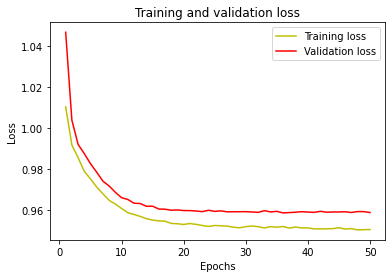

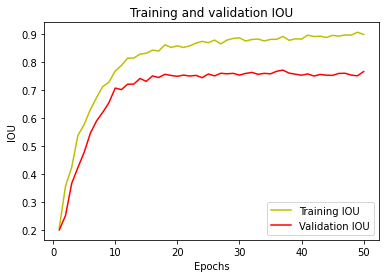

In [ ]:
#plot Loss nel train e nel test
loss = history1.history['loss']
val_loss = history1.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#plot IoU nel train e nel test
acc = history1.history['iou_score']
val_acc = history1.history['val_iou_score']
plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

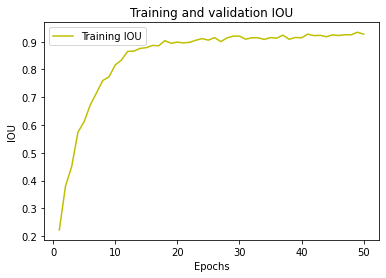

In [ ]:
#se voglio anche calcolare l'accuracy la devo istanziare nelle metrics

#accuracy = history1.history['f_score']
#accuracy
acc1 = history1.history['f1-score']
#val_acc = history1.history['val_iou_score']
plt.plot(epochs, acc1, 'y', label='Training IOU')
#plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

## 3.2 Load model

In [ ]:
# carico i modelli salvati precedentemente, dal PATH in cui sono
drive= '/content/drive/MyDrive/Computer Vision Project/Code/saved_models/res18_backbone_50epochs.hdf5'
from keras.models import load_model
model1 = load_model(drive, compile=False)
# no compile, perchè lo uso solo per la fase di valutazione

In [ ]:
sm.set_framework('tf.keras')
sm.framework()

BACKBONE1 = 'resnet34'
preprocess_input1 = sm.get_preprocessing(BACKBONE1)

## 3.3 Results

Mean IoU:

Mean IoU = 0.6082709 



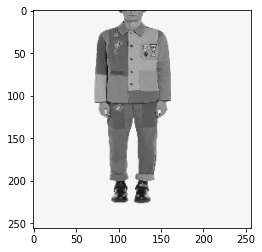

In [ ]:
# !!! ### #

#IOU
y_pred1=model1.predict(X_test1) # valutare che argomento passare
y_pred1_argmax=np.argmax(y_pred1, axis=3)

# !!! ottengo il risultato generale, media tra le classi
#n_classes = 15
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_test[:,:,:,0], y_pred1_argmax) # argomento da passare
print("Mean IoU =", IOU_keras.result().numpy(),'\n')

# MOSTRO LA VALUTAZIONE SULL'IMMAGINE
#prediction on first image
plt.imshow(images_save[0, :,:,0], cmap='gray') #images_save, train_images

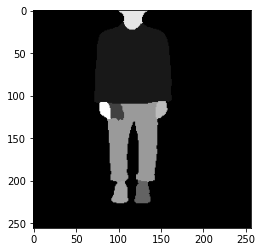

In [ ]:
plt.imshow(masks_save[0], cmap='gray') # masks_save, train_masks

In [ ]:
#MeanIoU, Accuracy, Precision, Recall

acc_keras = Accuracy()  
acc_keras.update_state(y_test[:,:,:,0], y_pred1_argmax) # argomento da passare
print("Accuracy =", acc_keras.result().numpy(),'\n')

Accuracy = 0.97537756 



In [ ]:
# da estendere a tutte le 15 classi

#IoU calcolato per ogni classe
values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)
print(values.shape)

classN_IoU= []

(15, 15)


In [ ]:
class0_IoU = values[0,0]/(values[0,0] + values[0,1] + values[0,2] + values[0,3] + values[0,4] + values[0,5] + values[0,6] + values[0,7] + values[0,8] + values[0,9] + values[0,10] + values[0,11] + values[0,12] + values[0,13] + values[0,14] + values[1,0]+ values[2,0]+ values[3,0] 
            + values[4,0] + values[5,0] + values[6,0] + values[7,0] + values[8,0] + values[9,0] + values[10,0] + values[11,0] + values[12,0] + values[13,0] + values[14,0])
classN_IoU.append(class0_IoU)

class1_IoU = values[1,1]/( values[1,0] + values[1,1] + values[1,2] + values[1,3] + values[1,4] + values[1,5] + values[1,6] + values[1,7] + values[1,8] + values[1,9] + values[1,10] + values[1,11] + values[1,12] + values[1,13] + values[1,14] + values[0,1]+ values[2,1]+ values[3,1] 
            + values[4,1] + values[5,1] + values[6,1] + values[7,1] + values[8,1] + values[9,1] + values[10,1] + values[11,1] + values[12,1] + values[13,1] + values[14,1])
classN_IoU.append(class1_IoU)

class2_IoU = values[2,2]/(values[2,0] + values[2,1] + values[2,2] + values[2,3] + values[2,4] + values[2,5] + values[2,6] + values[2,7] + values[2,8] + values[2,9] + values[2,10] + values[2,11] + values[2,12] + values[2,13] + values[2,14] + values[0,2]+ values[1,2]+ values[3,2] 
            + values[4,2] + values[5,2] + values[6,2] + values[7,2] + values[8,2] + values[9,2] + values[10,2] + values[11,2] + values[12,2] + values[13,2] + values[14,2])
classN_IoU.append(class2_IoU)

class3_IoU = values[3,3]/(values[3,0] + values[3,1] + values[3,2] + values[3,3] + values[3,4] + values[3,5] + values[3,6] + values[3,7] + values[3,8] + values[3,9] + values[3,10] + values[3,11] + values[3,12] + values[3,13] + values[3,14] + values[0,3]+ values[1,3]+ values[2,3] 
            + values[4,3] + values[5,3] + values[6,3] + values[7,3] + values[8,3] + values[9,3] + values[10,3] + values[11,3] + values[12,3] + values[13,3] + values[14,3])
classN_IoU.append(class3_IoU)

class4_IoU = values[4,4]/(values[4,0] + values[4,1] + values[4,2] + values[4,3] + values[4,4] + values[4,5] + values[4,6] + values[4,7] + values[4,8] + values[4,9] + values[4,10] + values[4,11] + values[4,12] + values[4,13] + values[4,14] + values[0,4]+ values[1,4]+ values[2,4] 
            + values[3,4] + values[5,4] + values[6,4] + values[7,4] + values[8,4] + values[9,4] + values[10,4] + values[11,4] + values[12,4] + values[13,4] + values[14,4])
classN_IoU.append(class4_IoU)

class5_IoU = values[5,5]/(values[5,0] + values[5,1] + values[5,2] + values[5,3] + values[5,4] + values[5,5] + values[5,6] + values[5,7] + values[5,8] + values[5,9] + values[5,10] + values[5,11] + values[5,12] + values[5,13] + values[5,14] + values[0,5]+ values[1,5]+ values[2,5] 
            + values[3,5] + values[4,5] + values[6,5] + values[7,5] + values[8,5] + values[9,5] + values[10,5] + values[11,5] + values[12,5] + values[13,5] + values[14,5]

)
classN_IoU.append(class5_IoU)

class6_IoU = values[6,6]/(values[6,0] + values[6,1] + values[6,2] + values[6,3] + values[6,4] + values[6,5] + values[6,6] + values[6,7] + values[6,8] + values[6,9] + values[6,10] + values[6,11] + values[6,12] + values[6,13] + values[6,14] + values[0,6]+ values[1,6]+ values[2,6] 
            + values[3,6] + values[4,6] + values[5,6] + values[7,6] + values[8,6] + values[9,6] + values[10,6] + values[11,6] + values[12,6] + values[13,6] + values[14,6]

)
classN_IoU.append(class6_IoU)

class7_IoU = values[7,7]/(values[7,0] + values[7,1] + values[7,2] + values[7,3] + values[7,4] + values[7,5] + values[7,6] + values[7,7] + values[7,8] + values[7,9] + values[7,10] + values[7,11] + values[7,12] + values[7,13] + values[7,14] + values[0,7]+ values[1,7]+ values[2,7] 
            + values[3,7] + values[4,7] + values[5,7] + values[6,7] + values[8,7] + values[9,7] + values[10,7] + values[11,7] + values[12,7] + values[13,7] + values[14,7]

)
classN_IoU.append(class7_IoU)

class8_IoU = values[8,8]/(values[8,0] + values[8,1] + values[8,2] + values[8,3] + values[8,4] + values[8,5] + values[8,6] + values[8,7] + values[8,8] + values[8,9] + values[8,10] + values[8,11] + values[8,12] + values[8,13] + values[8,14] + values[0,8]+ values[1,8]+ values[2,8] 
            + values[3,8] + values[4,8] + values[5,8] + values[6,8] + values[7,8] + values[9,8] + values[10,8] + values[11,8] + values[12,8] + values[13,8] + values[14,8]

)
classN_IoU.append(class8_IoU)

class9_IoU = values[9,9]/(values[9,0] + values[9,1] + values[9,2] + values[9,3] + values[9,4] + values[9,5] + values[9,6] + values[9,7] + values[9,8] + values[9,9] + values[9,10] + values[9,11] + values[9,12] + values[9,13] + values[9,14] + values[0,9]+ values[1,9]+ values[2,9] 
            + values[3,9] + values[4,9] + values[5,9] + values[6,9] + values[7,9] + values[8,9] + values[10,9] + values[11,9] + values[12,9] + values[13,9] + values[14,9]

)
classN_IoU.append(class9_IoU)

class10_IoU = values[10,10]/(values[10,0] + values[10,1] + values[10,2] + values[10,3] + values[10,4] + values[10,5] + values[10,6] + values[10,7] + values[10,8] + values[10,9] + values[10,10] + values[10,11] + values[10,12] + values[10,13] + values[10,14] + values[0,10]+ values[1,10]+                  values[2,10] + values[3,10] + values[4,10] + values[5,10] + values[6,10] + values[7,10] + values[8,10] + values[9,10] + values[11,10] + values[12,10] + values[13,10] + values[14,10]

)
classN_IoU.append(class10_IoU)

class11_IoU = values[11,11]/(values[11,0] + values[11,1] + values[11,2] + values[11,3] + values[11,4] + values[11,5] + values[11,6] + values[11,7] + values[11,8] + values[11,9] + values[11,10] + values[11,11] + values[11,12] + values[11,13] + values[11,14] + values[0,11]+ values[1,11]+                  values[2,11] + values[3,11] + values[4,11] + values[5,11] + values[6,11] + values[7,11] + values[8,11] + values[9,11] + values[10,11] + values[12,11] + values[13,11] + values[14,11]

)
classN_IoU.append(class11_IoU)

class12_IoU = values[12,12]/(values[12,0] + values[12,1] + values[12,2] + values[12,3] + values[12,4] + values[12,5] + values[12,6] + values[12,7] + values[12,8] + values[12,9] + values[12,10] + values[12,11] + values[12,12] + values[12,13] + values[12,14] + values[0,12]+ values[1,12]+                  values[2,12] + values[3,12] + values[4,12] + values[5,12] + values[6,12] + values[7,12] + values[8,12] + values[9,12] + values[10,12] + values[11,12] + values[13,12] + values[14,12]

)
classN_IoU.append(class12_IoU)

class13_IoU = values[13,13]/(values[13,0] + values[13,1] + values[13,2] + values[13,3] + values[13,4] + values[13,5] + values[13,6] + values[13,7] + values[13,8] + values[13,9] + values[13,10] + values[13,11] + values[13,12] + values[13,13] + values[13,14] + values[0,13]+ values[1,13]+                  values[2,13] + values[3,13] + values[4,13] + values[5,13] + values[6,13] + values[7,13] + values[8,13] + values[9,13] + values[10,13] + values[11,13] + values[12,13] + values[14,13]

)
classN_IoU.append(class13_IoU)

class14_IoU = values[14,14]/(values[14,0] + values[14,1] + values[14,2] + values[14,3] + values[14,4] + values[14,5] + values[14,6] + values[14,7] + values[14,8] + values[14,9] + values[14,10] + values[14,11] + values[14,12] + values[14,13] + values[14,14] + values[0,14]+ values[1,14]+                  values[2,14] + values[3,14] + values[4,14] + values[5,14] + values[6,14] + values[7,14] + values[8,14] + values[9,14] + values[10,14] + values[11,14] + values[12,14] + values[13,14]

)
classN_IoU.append(class14_IoU)

In [ ]:
for i in range(len(classN_IoU)):
    print('IoU for classes', i, 'is: \t', classN_IoU[i])

IoU for classes 0 is: 	 0.41014752
IoU for classes 1 is: 	 0.23260216
IoU for classes 2 is: 	 0.0
IoU for classes 3 is: 	 0.0005551126
IoU for classes 4 is: 	 0.0
IoU for classes 5 is: 	 0.0
IoU for classes 6 is: 	 3.8686962e-06
IoU for classes 7 is: 	 0.0
IoU for classes 8 is: 	 0.00010424992
IoU for classes 9 is: 	 0.32294285
IoU for classes 10 is: 	 0.0026492097
IoU for classes 11 is: 	 0.0
IoU for classes 12 is: 	 0.0
IoU for classes 13 is: 	 0.39235434
IoU for classes 14 is: 	 5.1826002e-05


## 4 Add more models

Se vogliamo possiamo fare delle valutazioni prendendo modelli diversi e confrontarli

In [ ]:
# load more models e ripetere il punto 3.2

## 5 Show results

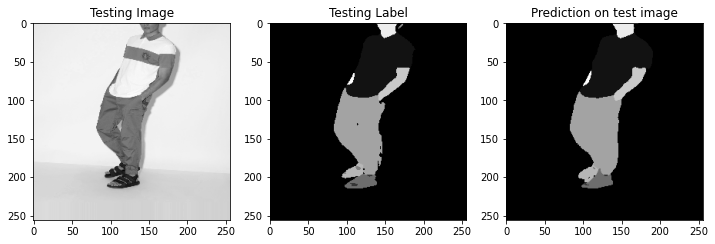

In [ ]:
#Test some random images
import random
test_img_number = random.randint(0, len(X_test1)) # prendo un'immagine a caso
test_img = X_test1[test_img_number]
ground_truth=y_test[test_img_number]
test_img_input=np.expand_dims(test_img, 0)

test_img_input1 = preprocess_input1(test_img_input) # procedimento di valutazione sull'immagine selezionata

test_pred1 = model1.predict(test_img_input1)
test_prediction1 = np.argmax(test_pred1, axis=3)[0,:,:]

plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_prediction1, cmap='gray')
plt.show()

VALUTAZIONE SU IMMAGINE MAI VISTA.

Devo aver caricato le librerie, la dimensione dell'immagine con cui lavoro e tutto il blocco load model!

In [ ]:
# lettura nuova immagine
# immagine spuria del dataset
new_path= '/content/output_1.jpg' #/content/46628915jp_0_d.jpg'
new_image= cv2.imread(new_path,1)
new_image = cv2.resize(new_image, (SIZE_Y, SIZE_X))
new_image= np.array(new_image)
new_image.shape #

(256, 256, 3)

In [ ]:
# valutazione immagine al di fuori del dataset

new_image_input=np.expand_dims(new_image, 0)
test_img_input1 = preprocess_input1(new_image_input) # procedimento di valutazione sull'immagine selezionata, nuova
test_pred1 = model1.predict(test_img_input1)
test_prediction1 = np.argmax(test_pred1, axis=3)[0,:,:]

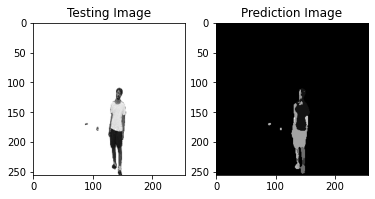

In [ ]:
plt.subplot(121)
plt.title('Testing Image')
plt.imshow(new_image[:,:,0], cmap='gray')
plt.subplot(122)
plt.title('Prediction Image')
plt.imshow(test_prediction1, cmap='gray')
plt.show()

In [ ]:
plt.imshow(test_prediction1, cmap='gray')
cv2.imwrite("output_2.jpg", test_prediction1)

In [ ]:
# controllo
print(test_img_input1.shape)
print(test_pred1.shape)
print(test_prediction1.shape)

(1, 256, 256, 3)
(1, 256, 256, 15)
(256, 256)


In [ ]:
# metriche
'''
scores = model.evaluate_generator(test_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))
'''

In [ ]:
# random prove dei risultati
'''
n = 5
ids = np.random.choice(np.arange(len(test_dataset)), size=n)

for i in ids:
    image, gt_mask = test_dataset[i]
    image = np.expand_dims(image, axis=0)
    pr_mask = model.predict(image)
    
    visualize(
        image=denormalize(image.squeeze()),
        gt_mask=gt_mask.squeeze(),
        pr_mask=pr_mask.squeeze(),
    )
'''

TODO:

far vedere con un colore quale parte dell'immagine presa come testing è classificata come maglietta nel risultato della predizione.

[evidenzio i pixel del 'colore classe' della maglietta nella predizione che ho fattom (pixel_value=#14)]

Funzione simile presente nel util.py di segmentation!

COSE ANCORA DA FARE:

- estendere ad altri modelli

- ampliare il dataset su cui si lavora

